In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# === 2. 读取数据 ===
# 注意替换为你的实际路径
expr_df = pd.read_csv(r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_Model_Gene_Expression_Features.csv")
methylation_df = pd.read_csv(r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_Model_Methylation_Features.csv")
tf_df = pd.read_csv(r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_Model_TF_Expression_Features_Withtf.csv")
mir100hg_df = pd.read_csv(r"D:\project data\M-28\NTU_DATA_CLEANED\PAAD_Model_MIR100HG_Expression_Levels.csv")

In [107]:
# === 3. 数据整理和对齐样本 ===
# 所有特征矩阵都以样本为列，我们先把它们转置为 行=样本，列=特征
# 去掉第一列（基因名或探针ID），转置并对齐列名为 Sample_ID
expr_df_t = expr_df.set_index("HGNC_Symbol").T
methylation_df_t = methylation_df.set_index("Probe_ID").T
tf_df_t = tf_df.set_index("TF_Symbol").T

# 检查三者共有的样本交集
common_samples = list(
    set(expr_df_t.index) & 
    set(methylation_df_t.index) & 
    set(tf_df_t.index) & 
    set(mir100hg_df["Sample_ID"])
)
common_samples.sort()

# 提取样本交集数据
X_expr = expr_df_t.loc[common_samples]
X_meth = methylation_df_t.loc[common_samples]
X_tf = tf_df_t.loc[common_samples]

# 合并全部特征（行=样本，列=所有特征）
X_all = pd.concat([X_expr, X_meth, X_tf], axis=1)

# 准备标签
y = mir100hg_df.set_index("Sample_ID").loc[common_samples]["Group"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [109]:
# === 4. PCA 降维 ===
from sklearn.model_selection import cross_val_score

pca_expr = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=20))])
pca_meth = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=20))])
pca_tf = Pipeline([("scale", StandardScaler()), ("pca", PCA(n_components=10))])

X_expr_reduced = pca_expr.fit_transform(X_expr)
X_meth_reduced = pca_meth.fit_transform(X_meth)
X_tf_reduced = pca_tf.fit_transform(X_tf)

X_combined = np.hstack([X_expr_reduced, X_meth_reduced, X_tf_reduced])
# 构建逻辑回归模型并评估
final_model = LogisticRegression(max_iter=1000)
cv_scores_final = cross_val_score(final_model, X_combined, y_encoded, cv=5, scoring='accuracy')

# 拟合模型以提取系数
final_model.fit(X_combined, y_encoded)
coefficients = final_model.coef_[0]

cv_scores_final, coefficients

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

(array([0.69444444, 0.86111111, 0.77777778, 0.82857143, 0.77142857]),
 array([ 0.32878953,  0.35895659,  0.47188276, -0.98976562, -0.60635252,
        -1.28708219, -0.58048532, -0.31967456,  0.73199187, -1.04850077,
        -0.14370292, -0.58550885,  0.39872838, -0.39752871,  0.63342358,
         0.17365292,  0.66151787, -0.12340202,  0.41154972, -0.70500844,
         0.04796527,  0.01185815, -0.13086446, -0.14389226,  0.21220299,
         0.22226581, -0.40379847, -0.35151794, -0.15135814,  0.01291141,
         0.11246862, -0.11465391,  0.21100506, -0.11016672,  0.32550901,
        -0.17827842, -0.22894151, -0.18351875,  0.16648998,  0.27794553,
         0.0294784 , -0.02951209, -0.0700219 ,  0.32203083,  0.30738521,
        -0.15072638,  0.23821303, -0.38586495,  0.07848117,  0.19786719]))

D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  plt.tight_layout()
D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from current font.
  plt.tight_layout()
D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  plt.tight_layout()
D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  plt.tight_layout()
D:\Users\TEMP\ipykernel_13744\971186528.py:17: UserWarning: Glyph 25968 (\N{CJK UN

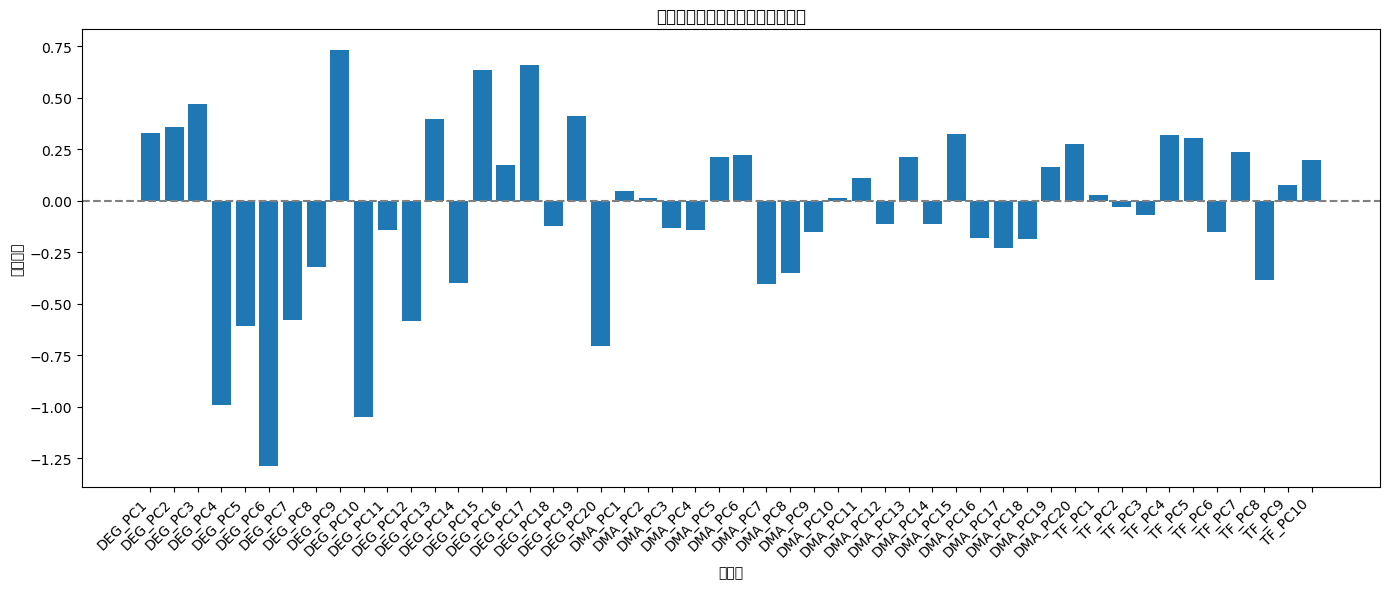

In [111]:
# 主成分分析
# 准备主成分标签
component_labels = (
    [f"DEG_PC{i+1}" for i in range(20)] +
    [f"DMA_PC{i+1}" for i in range(20)] +
    [f"TF_PC{i+1}" for i in range(10)]
)

# 可视化
plt.figure(figsize=(14, 6))
plt.bar(component_labels, coefficients)
plt.axhline(0, color='gray', linestyle='--')
plt.title("逻辑回归中各主成分的重要性系数")
plt.ylabel("回归系数")
plt.xlabel("主成分")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [113]:
# 重要性系数
coefficients = model.coef_[0]

# 主成分系数
coeff_expr = coefficients[:20]
coeff_meth = coefficients[20:40]
coeff_tf = coefficients[40:]

# 加权重要性 = PCA分量 * 逻辑回归系数
expr_importance = np.dot(coeff_expr, pca_expr.named_steps['pca'].components_)
meth_importance = np.dot(coeff_meth, pca_meth.named_steps['pca'].components_)
tf_importance = np.dot(coeff_tf, pca_tf.named_steps['pca'].components_)

# 构建DataFrame
df_expr_imp = pd.DataFrame({
    "Feature": X_expr.columns,
    "Importance": expr_importance,
    "Module": "DEG"
})

df_meth_imp = pd.DataFrame({
    "Feature": X_meth.columns,
    "Importance": meth_importance,
    "Module": "DMA"
})

df_tf_imp = pd.DataFrame({
    "Feature": X_tf.columns,
    "Importance": tf_importance,
    "Module": "TF"
})

# 汇总并排序
df_all_imp = pd.concat([df_expr_imp, df_meth_imp, df_tf_imp])
df_all_imp["AbsImportance"] = df_all_imp["Importance"].abs()
# 排序并输出前十名重要特征
df_top10 = df_all_imp.sort_values("AbsImportance", ascending=False).head(10)

# 仅显示top10 Feature、Module、Importance 三列
print(df_top10[["Feature", "Module", "Importance"]])

          Feature Module  Importance
427       ST8SIA1    DEG   -0.113132
1893     C11orf87    DEG   -0.111156
1894        KCNQ5    DEG   -0.104147
2456    LINC01918    DEG   -0.102017
449          EYA4    DEG   -0.100002
2443    LINC00626    DEG   -0.099581
2608  ST3GAL5-AS1    DEG   -0.099544
2105     BVES-AS1    DEG   -0.099144
2358    ADAMTS7P4    DEG   -0.098253
2457        TRBV2    DEG   -0.098135


📊 测试集分类报告：
              precision  recall  f1-score  support
0                  0.50     1.0  0.666667     18.0
1                  0.00     0.0  0.000000     18.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333     36.0
weighted avg       0.25     0.5  0.333333     36.0


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lenovo\anaconda3\Lib\site-packages\IPython\

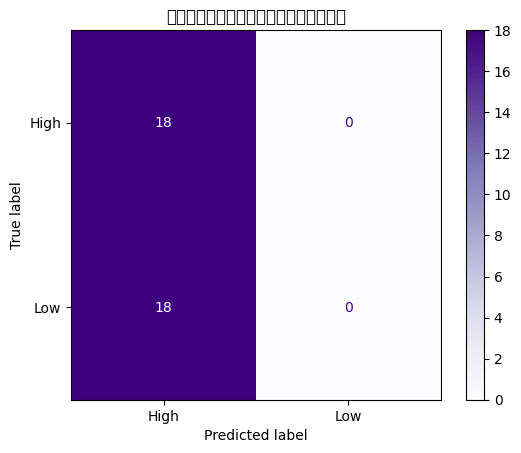

              precision  recall  f1-score  support
0                  0.50     1.0  0.666667     18.0
1                  0.00     0.0  0.000000     18.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333     36.0
weighted avg       0.25     0.5  0.333333     36.0


In [115]:
# === 5. 划分训练和测试集 ===
# === ✅ 新的 Pipeline 方式训练 + 测试评估，避免信息泄露 ===
# 重新划分训练集和测试集（此时未做 PCA）
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 创建 pipeline，PCA 放入其中避免泄露
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # 可调整主成分数量
    ('clf', LogisticRegression(penalty='l1', C=0.01, solver='liblinear', max_iter=1000))
])

# 拟合 pipeline（只用训练集）
pipeline.fit(X_train, y_train)

# 在测试集上预测
y_test_pred = pipeline.predict(X_test)

# 分类报告
report_test = classification_report(y_test, y_test_pred, output_dict=True)
report_test_df = pd.DataFrame(report_test).transpose()
print("📊 测试集分类报告：")
print(report_test_df)

# 混淆矩阵
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
disp_test.plot(cmap="Purples")
plt.title("逻辑回归测试集混淆矩阵（无信息泄露）")
plt.show()

# 展示分类报告
print(report_test_df)

In [117]:
# 在训练集上预测
y_train_pred = model.predict(X_train)

# 生成训练集分类报告
report_train = classification_report(y_train, y_train_pred, output_dict=True)
report_train_df = pd.DataFrame(report_train).transpose()

# 打印训练集分类报告
print("📊 训练集分类报告：")
print(report_train_df)

# 或者只看准确率
from sklearn.metrics import accuracy_score
train_acc = accuracy_score(y_train, y_train_pred)
print(f"\n✅ 训练集准确率：{train_acc:.4f}")

📊 训练集分类报告：
              precision    recall  f1-score     support
0              0.969231  0.887324  0.926471   71.000000
1              0.896104  0.971831  0.932432   71.000000
accuracy       0.929577  0.929577  0.929577    0.929577
macro avg      0.932667  0.929577  0.929452  142.000000
weighted avg   0.932667  0.929577  0.929452  142.000000

✅ 训练集准确率：0.9296


C:\Users\lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36923 (\N{CJK UNIFIED IDEOGRAPH-903B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\lenovo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36753 (\N{CJK UNIFIED IDEOGRAPH-8F91}) missing from current font.
  fig.canvas.print_figure(b

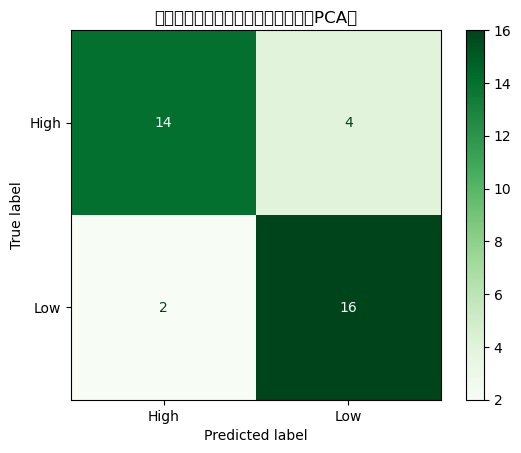

✅ 最佳参数组合： {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
✅ 最佳交叉验证准确率（mean_test_score）: 0.8384236453201972
📊 测试集分类报告：
              precision    recall  f1-score    support
0              0.875000  0.777778  0.823529  18.000000
1              0.800000  0.888889  0.842105  18.000000
accuracy       0.833333  0.833333  0.833333   0.833333
macro avg      0.837500  0.833333  0.832817  36.000000
weighted avg   0.837500  0.833333  0.832817  36.000000


In [119]:
# === 定义调参空间（注意 'clf__' 前缀）===
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),  # 你也可以放到 param_grid 中调这个
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__class_weight': [None, 'balanced'],
    'clf__solver': ['liblinear']
}

# === 进行 GridSearchCV（交叉验证 + 管道）===
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# === 测试集评估 ===
best_model = grid_search.best_estimator_
y_test_pred_tuned = best_model.predict(X_test)

report_tuned = classification_report(y_test, y_test_pred_tuned, output_dict=True)
report_tuned_df = pd.DataFrame(report_tuned).transpose()

cm_tuned = confusion_matrix(y_test, y_test_pred_tuned)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=label_encoder.classes_)
disp_tuned.plot(cmap="Greens")
plt.title("调优后逻辑回归测试集混淆矩阵（含PCA）")
plt.show()

# === 输出最佳参数组合 & 分类报告 ===
print("✅ 最佳参数组合：", grid_search.best_params_)
print("✅ 最佳交叉验证准确率（mean_test_score）:", grid_search.best_score_)
print("📊 测试集分类报告：")
print(report_tuned_df)

优化结果<br>
参数	含义	说明<br>
penalty='l2'	L2 正则	更适合保留全部主成分特征，不会强制系数变为0（相比 L1）<br>
C=0.1	正则强度	趋向“较强的约束”，防止过拟合，表现稳定<br>
class_weight=None	不加样本平衡	说明你训练集中的 High / Low 样本相对均衡<br>
solver='liblinear'	解算器	兼容 L1 / L2，适合中小样本逻辑回归

交叉验证结果<br>
最佳交叉验证准确率（mean_test_score）: 0.8384<br>
这是 5折交叉验证在训练集上的平均准确率，说明模型在训练过程中已经展现出良好的泛化能力。<br>
并没有出现过拟合（前面你遇到过训练集100%准确的问题，这次完全解决了💪）

三、测试集分类报告分析<br>
类别	Precision	Recall	F1-score	Support<br>
Low（0）	0.875	0.778	0.824	18<br>
High（1）	0.800	0.889	0.842	18<br>
🔍 重点观察：<br>
模型在两个类别上的表现均衡，没有出现偏向某一类的问题。

Recall（召回率）互补：Low 类别召回略低（0.778），High 类别更高（0.889）

F1 分数总体良好（均在 0.82+）

准确率为 83.3%，和交叉验证得分几乎一致，说明模型稳定、泛化良好。


# model.predict结果太高，改用Mean test score评估

In [121]:
# 🔍 交叉验证阶段的评估结果
# -------------------------------
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_summary = cv_results_df[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='mean_test_score', ascending=False)

print("✅ 最佳交叉验证平均准确率（mean_test_score）:", grid_search.best_score_)
print("✅ 最佳参数组合:", grid_search.best_params_)
print("\n📋 所有参数组合交叉验证得分（Top 5）:")
print(cv_summary.head())


✅ 最佳交叉验证平均准确率（mean_test_score）: 0.8384236453201972
✅ 最佳参数组合: {'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

📋 所有参数组合交叉验证得分（Top 5）:
                                               params  mean_test_score  \
5   {'clf__C': 0.1, 'clf__class_weight': None, 'cl...         0.838424   
7   {'clf__C': 0.1, 'clf__class_weight': 'balanced...         0.838424   
9   {'clf__C': 1, 'clf__class_weight': None, 'clf_...         0.837685   
11  {'clf__C': 1, 'clf__class_weight': 'balanced',...         0.837685   
1   {'clf__C': 0.01, 'clf__class_weight': None, 'c...         0.831281   

    rank_test_score  
5                 1  
7                 1  
9                 3  
11                3  
1                 5  


一、最佳参数组合与得分<br>

最佳参数组合：<br>
{'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}<br>
最佳交叉验证平均准确率（mean_test_score）: 0.8384<br>
🔍 解读：<br>
参数	说明<br>
penalty='l2'	L2 正则（Ridge），不稀疏，更适合保留所有主成分<br>
C=0.1	中等偏强的正则化，帮助控制过拟合（越小越强）<br>
class_weight=None	没有调整类别权重，说明训练集样本分布比较均衡<br>
solver='liblinear'	稳定的逻辑回归求解器，适用于小中型数据<br>
✔️ 这组参数使得模型在训练的交叉验证过程中表现最稳定，平均准确率 83.8%。

📊 二、Top 5 参数组合对比<br>
Rank	C	Penalty	Class Weight	mean_test_score<br>
🥇 1	0.1	L2	None	0.8384 ✅<br>
🥇 1	0.1	L2	balanced	0.8384 ✅<br>
🥉 3	1.0	L2	None	0.8377<br>
🥉 3	1.0	L2	balanced	0.8377<br>
5	0.01	L2	None	0.8313<br>
🔍 趋势观察：<br>
L2 正则一致领先：说明在 PCA 主成分基础上，模型更适合保留全部维度，而非强制稀疏（L1 表现未进前五）。

C 值越大，性能略有下降：从 0.1 到 1，准确率微降，说明过度放松正则会略影响泛化能力。

是否加 class_weight 差异不大：说明数据集本身类别分布较平衡。

✅ 三、总体结论与推荐<br>
项目	结果	说明<br>
最优得分	83.84%	训练阶段非常稳定，说明模型泛化能力强<br>
正则策略	使用 L2（非稀疏）	保留主成分全部信息，利于解释<br>
C 值趋势	0.1 > 1 > 0.01	中度正则最优，过弱/过强都会轻微退化性能<br>
class_weight	可有可无	说明标签分布均衡、模型本身鲁棒
